In [1]:
import os
import cv2 
import itertools
import numpy as np 
import pandas as pd 

test_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/"
train_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/"

data = []


In [2]:
for dirtrain in os.listdir(train_dir): 
    print(dirtrain)
    for tr in os.listdir(train_dir + dirtrain):
        img = cv2.imread(train_dir + dirtrain + "/" + tr)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape(32, 32, 1)
        
        data.append([img, dirtrain])     

ModerateDemented
NonDemented
VeryMildDemented
MildDemented


In [3]:
for dirtest in  os.listdir(test_dir):    
    print(dirtest)
    for ts in os.listdir(test_dir + dirtest):
        img = cv2.imread(test_dir + dirtest + "/" + ts)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape(32, 32, 1)
        
        data.append([img, dirtest])

ModerateDemented
NonDemented
VeryMildDemented
MildDemented


In [4]:
import random
random.seed(20)

In [5]:
random.shuffle(data)

In [6]:
x, y = [], []
for e in data:
    x.append(e[0])
    y.append(e[1])

In [7]:
from sklearn.preprocessing import OneHotEncoder

x = np.array(x)
y = np.array(y)
y = y.reshape(y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore').fit(y)
print(enc.categories_)
y = enc.transform(y).toarray()
print(f'Data   :   {str(x.shape)}')
print(f'Labels :   {str(y.shape)}')

[array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')]
Data   :   (6400, 32, 32, 1)
Labels :   (6400, 4)


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)

In [9]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [11]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (4, 4), padding='same', activation=tf.nn.relu, 
    input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)), Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),

    tf.keras.layers.Conv2D(128, (2,2), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),

    tf.keras.layers.Conv2D(256, (2,2), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),
                    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4,  activation=tf.nn.softmax)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

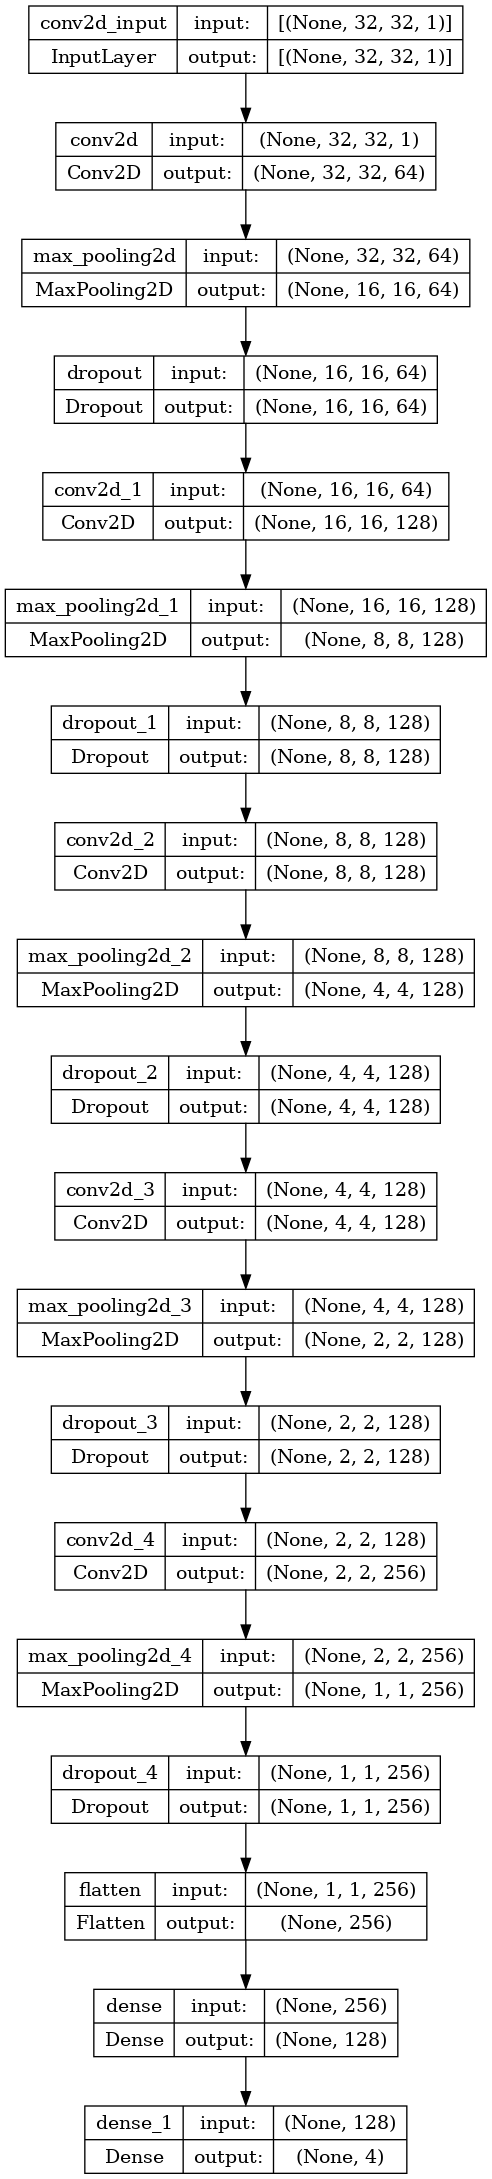

In [13]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [14]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist = model.fit(x_train, y_train, epochs=200, validation_split=0.2, batch_size=64,verbose=1,shuffle=True)

Epoch 1/200


2024-03-27 20:26:53.181579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - 9s 13ms/step - loss: 1.7947 - accuracy: 0.4568 - val_loss: 1.1257 - val_accuracy: 0.5088
Epoch 2/200
64/64 [==============================] - 0s 8ms/step - loss: 1.0439 - accuracy: 0.4895 - val_loss: 1.0339 - val_accuracy: 0.5088
Epoch 3/200
64/64 [==============================] - 0s 8ms/step - loss: 0.9918 - accuracy: 0.5120 - val_loss: 0.9534 - val_accuracy: 0.5293
Epoch 4/200
64/64 [==============================] - 0s 8ms/step - loss: 0.9784 - accuracy: 0.5173 - val_loss: 0.9280 - val_accuracy: 0.5547
Epoch 5/200
64/64 [==============================] - 0s 8ms/step - loss: 0.9569 - accuracy: 0.5186 - val_loss: 0.9480 - val_accuracy: 0.5732
Epoch 6/200
64/64 [==============================] - 0s 8ms/step - loss: 0.9540 - accuracy: 0.5347 - val_loss: 1.0205 - val_accuracy: 0.5400
Epoch 7/200
64/64 [==============================] - 0s 8ms/step - loss: 0.9709 - accuracy: 0.5173 - val_loss: 0.9317 - val_accuracy: 0.5098
Epoch 8/200
64/64 [=====

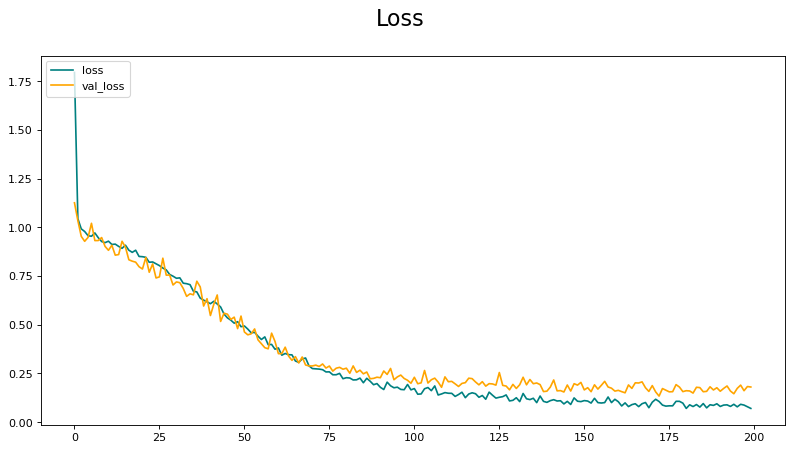

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(12, 6), dpi=80)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

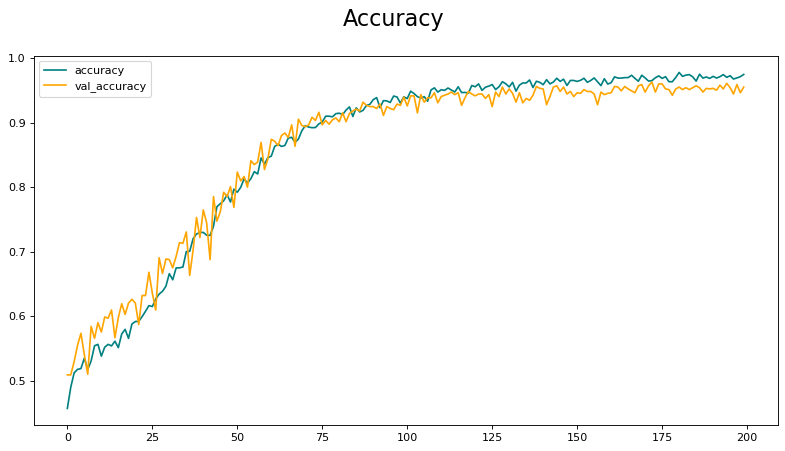

In [16]:
fig = plt.figure(figsize=(12, 6), dpi=80)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [17]:
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)
y_pred = model.predict(x_test).argmax(axis=1)
print(f'Test Loss     : {loss_and_metrics[0]}')
print(f'Test Accuracy : {loss_and_metrics[1]}')
print(y_test.shape, y_pred.shape)

40/40 - 0s - loss: 0.1285 - accuracy: 0.9617 - 361ms/epoch - 9ms/step
40/40 [==============================] - 0s 2ms/step
Test Loss     : 0.12852796912193298
Test Accuracy : 0.961718738079071
(1280, 4) (1280,)


In [18]:
from sklearn import metrics

df = pd.DataFrame(
  data = metrics.confusion_matrix(np.argmax(y_test, axis=1), y_pred),
  columns = ['0', '1', '2', '3'],
  index = ['0', '1', '2', '3']
)
df

,0,1,2,3
0,165,0,0,2
1,0,11,0,0
2,5,0,616,11
3,9,0,22,439


<Axes: >

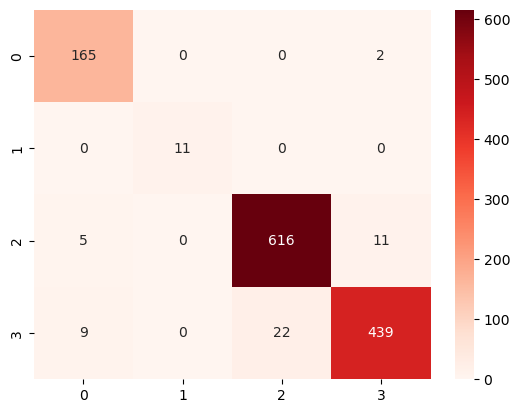

In [19]:
import seaborn as sns

sns.heatmap(df, cmap="Reds", annot=True, fmt='.0f')